In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st

import random
from scipy import stats
from matplotlib import gridspec

In [4]:
N_episode = 100  # Number of episodes
N_timestep = 200  # Number of timesteps
mouth = 2  # Volume of an intake
fs = 20  # Font size

class Train:
    def __init__(self):
        self.N = N_timestep
        self.a = np.zeros(self.N)  # 0 or 1
        self.D = np.zeros(self.N+1)  # d(Ht)
        self.D_est = np.zeros(self.N+1)  # d(Ht+1)
        self.H = np.zeros(self.N+1)  # internal state
        self.H[0] = 100  # depleted internal state
        self.H_ast = 200  # setpoint
        self.P = np.zeros(self.N)  # p(intake)

        self.K = np.zeros(self.N)  # K
        self.K_hat = np.zeros((2, self.N+1))  # K hat
        self.Q = np.zeros((2, self.N+1))  # Q value
        
        self.R = np.zeros(self.N)  # reward
        
        ### parameter ###########################        
        self.alpha_Q = 0.3  # learning rate of Q
        self.beta = 0.6  # inverse temperature
        self.gamma = 0.9  # discount rate
        self.tau = 200  # attenuation rate of the internal state
        self.alpha_K_hat = 0.3  # learning rate of K_hat
        self.mouth = mouth  # volume of an intake
        
        self.m = 3
        self.n = 4
        
        self.K_hat[1][0] = self.mouth
        #########################################
        

    def softmax(self, t):
        self.t = t
        sigma = np.sum(np.exp(self.Q[:, self.t] * self.beta))
        vals = []
        for i in range(2):
            softmax = np.exp(self.Q[i, self.t] * self.beta) / sigma
            vals.append(softmax)
            if i == 1:
                self.P[self.t] = softmax
            
        dice = random.random()
        if dice <= vals[0]:
            self.a[self.t] = 0
        elif vals[0] < dice:
            self.a[self.t] = 1

            
    def get_intake(self, t):
        self.t = t
        if self.a[self.t] == 1:
            self.K[self.t] = self.mouth
            

    def get_drive(self, t):
        self.t = t
        self.D[self.t] =  (abs(self.H_ast - self.H[self.t]) ** self.n) ** (1 / self.m)
        if self.a[self.t] == 1:  # intake
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1 / self.tau) * self.H[self.t] - self.K[self.t]) ** self.n) ** (1 / self.m)
        else:
            self.D_est[self.t] = (abs(self.H_ast - (1 - 1 / self.tau) * self.H[self.t]) ** self.n) ** (1 / self.m)


    def update_K_hat(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.K[self.t] = 0
            self.K_hat[0][self.t + 1] = self.K_hat[0][self.t]
            self.K_hat[1][self.t + 1] = self.K_hat[1][self.t]
            
        else:
            self.K[self.t] = self.mouth
            self.K_hat[0][self.t + 1] = self.K_hat[0][self.t]
            self.K_hat[1][self.t + 1] = (1 - self.alpha_K_hat) * self.K_hat[1][self.t] + self.alpha_K_hat * self.mouth


    def get_reward(self, t):
        self.t = t
        if self.H[self.t] < 50 :
            self.R[self.t] = self.D[self.t] - self.D_est[self.t]
        else:
            self.R[self.t] = self.D[self.t] - self.D_est[self.t]
    

    def update_H(self, t):
        self.t = t
        self.H[self.t+1] = (1 - 1/self.tau) * self.H[self.t] + self.K[self.t]


    def update_Q(self, t):
        self.t = t
        if self.a[self.t] == 0:
            self.Q[0][self.t+1] = self.Q[0][self.t] + self.alpha_Q * (self.R[self.t] + self.gamma * max(self.Q[0][self.t], self.Q[1][self.t]) - self.Q[0][self.t])
            self.Q[1][self.t+1] = self.Q[1][self.t]
            
        elif self.a[self.t] == 1:
            self.Q[0][self.t + 1] = self.Q[0][self.t]
            self.Q[1][self.t + 1] = self.Q[1][self.t] + self.alpha_Q * (self.R[self.t] + self.gamma * max(self.Q[0][self.t], self.Q[1][self.t]) - self.Q[1][self.t])

#============================

num_l = list(range(N_timestep + 1))
Nexp_l = list(range(N_episode))

a_H = np.zeros(N_episode * (N_timestep + 1))
a_Q0 = np.zeros(N_episode * (N_timestep + 1))
a_Q1 = np.zeros(N_episode * (N_timestep + 1))


a_P = np.zeros(N_episode * (N_timestep + 1))
a_a = np.zeros(N_episode * (N_timestep + 1))
a_R = np.zeros(N_episode * (N_timestep + 1))
a_K_hat = np.zeros(N_episode * (N_timestep + 1))



class_l = []

# To make list of Classes
for i in range(N_episode):
    class_l.append(None)


# main
for j in range(N_episode):
    class_l[j] = Train()    
    for i in range(N_timestep):
        class_l[j].softmax(i)
        class_l[j].get_intake(i)
        class_l[j].get_drive(i)
        class_l[j].update_K_hat(i)
        class_l[j].get_reward(i)
        class_l[j].update_Q(i)
        class_l[j].update_H(i)
        
    
    a_H[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = class_l[j].H
    a_Q0[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = class_l[j].Q[0]
    a_Q1[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = class_l[j].Q[1]
    a_P[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = np.append(class_l[j].P, np.nan)
    a_a[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = np.append(class_l[j].a, np.nan)
    a_R[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = np.append(class_l[j].R, np.nan)
    a_K_hat[(N_timestep + 1) * j : (N_timestep + 1) * (j + 1)] = class_l[j].K_hat[1]

                   
df = pd.DataFrame(data=list(range((N_timestep + 1))) * N_episode, columns=['trial'])
df['H'] = a_H
df['Q0'] = a_Q0
df['Q1'] = a_Q1
df['P'] = a_P
df['A'] = a_a
df['R'] = a_R
df['K_hat'] = a_K_hat

/Users/yuukiuchida/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/yuukiuchida/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


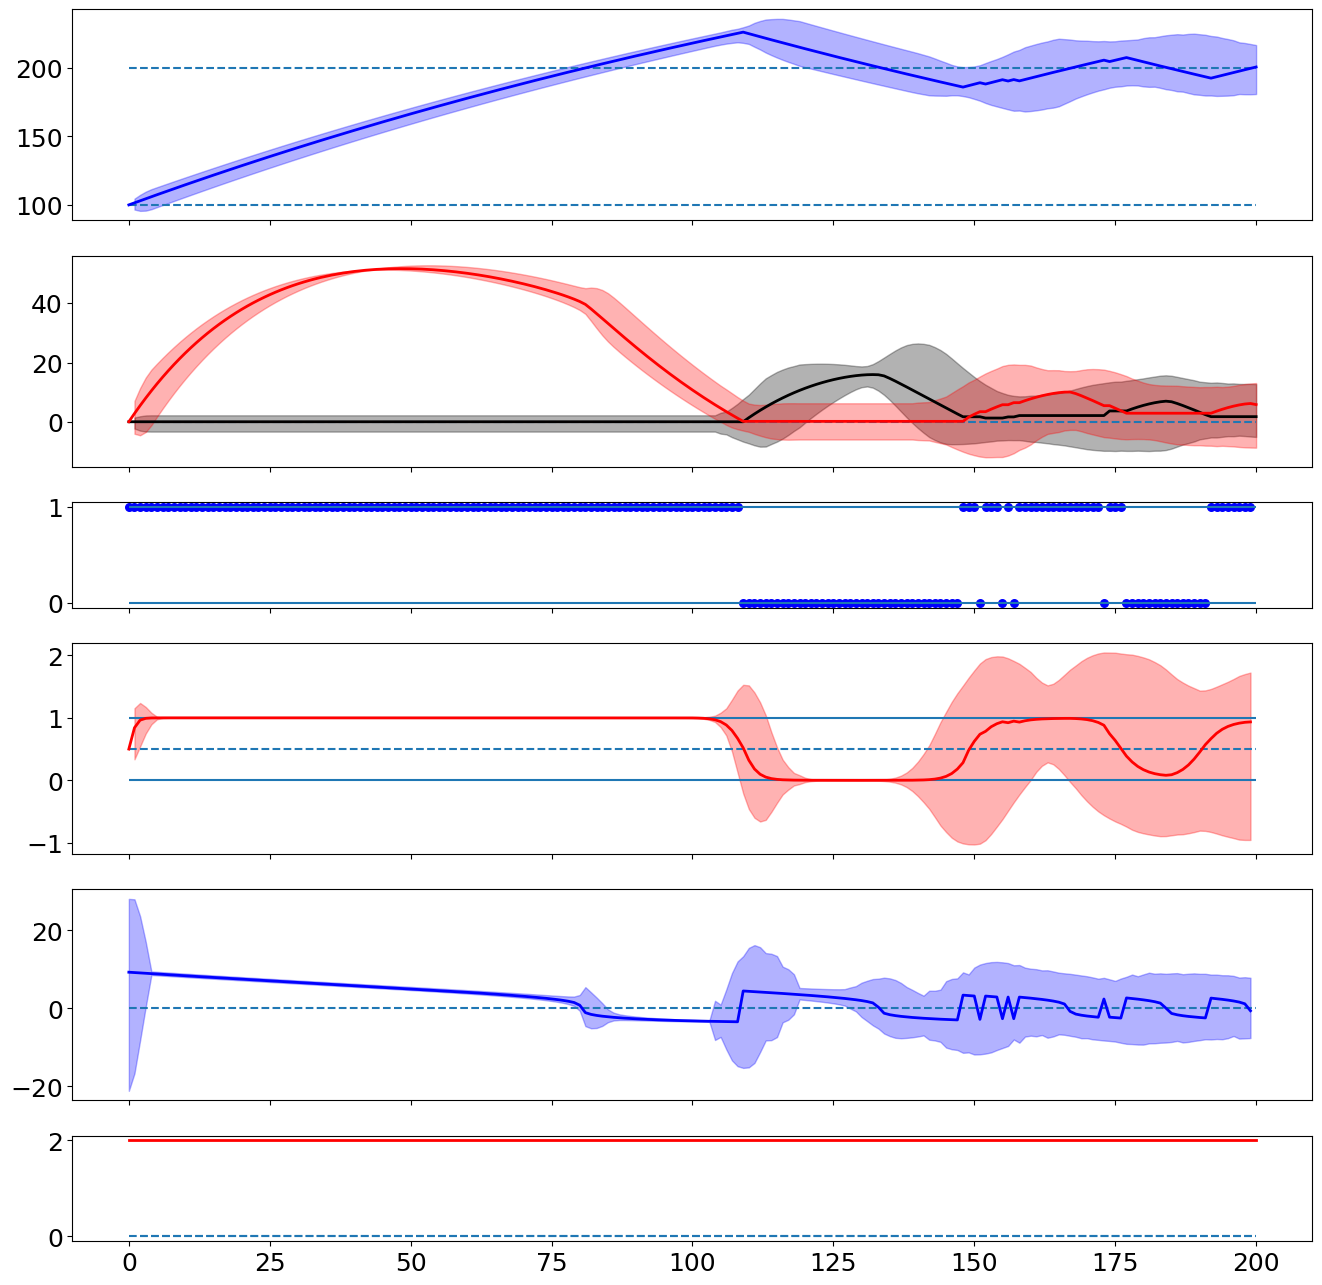

In [5]:
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(16,16))

N_figure = 6
spec = gridspec.GridSpec(ncols = 1, nrows = N_figure, height_ratios = [2,2,1,2,2,1])

ax_l = []
for i in range(N_figure):
    ax_l.append(fig.add_subplot(spec[i]))

CL = 0.95  # Confidencial Level for Figures
Df = N_episode - 1  # degree of freedom for Figures

mean = [] # mean at t
STD = []
CI = np.zeros((N_figure, N_timestep + 1, 2))  # confidence interval at t


for j, h in zip(['H','Q0','Q1','P','R','K_hat'], list(range(N_figure))):
    for i in range(N_timestep + 1):
        mean.append(sum(df.loc[df['trial'] == i][j]) / N_episode)
        #SE.append(stats.sem(df.loc[df['trial']==i][j]))
        #CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = SE[-1])[0]
        #CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = SE[-1])[1]
        STD.append(st.stdev(df.loc[df['trial'] == i][j]))
        CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2 * STD[-1])[0]
        CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2 * STD[-1])[1]
        
         
length_l, length_s = N_timestep + 1, N_timestep


ax_l[0].hlines(200, 0, N_timestep, linestyle="dashed")
ax_l[0].hlines(100, 0, N_timestep, linestyle="dashed")
ax_l[0].plot(df['H'][:length_l], linewidth=2, color='blue')
ax_l[0].fill_between(df.index[:length_l], CI[0, :, 0], CI[0, :, 1], color='blue', alpha=.3) #confidence interval curves.
ax_l[0].tick_params(labelbottom=False)


ax_l[1].hlines(0, 0, N_timestep, linestyle="dashed")
ax_l[1].plot(df['Q0'][:length_l], linewidth=2, color='black')
ax_l[1].fill_between(df.index[:length_l], CI[1, :, 0], CI[1, :, 1], color='black', alpha=.3) #confidence interval curves.
ax_l[1].plot(df['Q1'][:length_l], linewidth=2, color='red')
ax_l[1].fill_between(df.index[:length_l], CI[2, :, 0], CI[2, :, 1], color='red', alpha=.3) #confidence interval curves.
ax_l[1].tick_params(labelbottom=False)


ax_l[2].hlines(1, 0, N_timestep)
ax_l[2].hlines(0, 0, N_timestep)
ax_l[2].scatter(list(range(length_s)), df['A'][:length_s], s=30, c='blue')
ax_l[2].tick_params(labelbottom=False)


ax_l[3].hlines(0, 0, N_timestep)
ax_l[3].hlines(0.5, 0, N_timestep,  linestyle="dashed")
ax_l[3].hlines(1, 0, N_timestep)
ax_l[3].plot(df['P'][:length_s], linewidth=2, color='red')
ax_l[3].fill_between(df.index[:length_s], CI[3, :, 0][:length_s], CI[3, :, 1][:length_s], color='red', alpha=.3) #confidence interval curves.
ax_l[3].tick_params(labelbottom=False)


ax_l[4].hlines(0, 0, N_timestep, linestyle="dashed")
ax_l[4].plot(df['R'][:length_s], linewidth=2, color='blue')
ax_l[4].fill_between(df.index[:length_s], CI[4, :, 0][:length_s], CI[4, :, 1][:length_s], color='blue', alpha=.3) #confidence interval curves.
ax_l[4].tick_params(labelbottom=False)


ax_l[5].hlines(0, 0, N_timestep, linestyle="dashed")
ax_l[5].hlines(0, mouth, N_timestep, linestyle="dashed")
ax_l[5].plot(df['K_hat'][:length_l], linewidth=2, color='red')
ax_l[5].fill_between(df.index[:length_l], CI[5, :, 0], CI[5, :, 1], color='red', alpha=.3) #confidence interval curves.

